This model is built on this [repo](https://github.com/spdin/time-series-prediction-lstm-pytorch).

### Read data

In [9]:
import pandas as pd

df = pd.read_csv('data.csv')  # read df from csv file

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H;%M:%S')
df = df.drop(columns=['Date', 'Time'])
df.set_index('Datetime', inplace=True)

print(df[:5])

                      Load
Datetime                  
2007-10-01 00:00:00  1.324
2007-10-01 00:01:00  1.320
2007-10-01 00:02:00  1.318
2007-10-01 00:03:00  1.320
2007-10-01 00:04:00  1.312


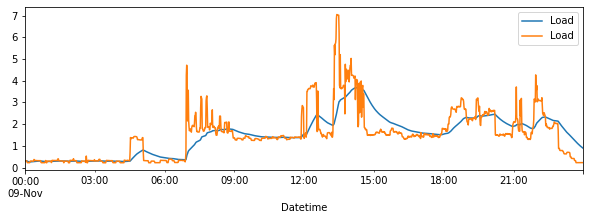

In [10]:
target_date=['2007-11-09']

def plot_data(df, target_date):
    for tar in target_date:
        one_day_data = df.loc[tar]
        ax = one_day_data.ewm(alpha=1/50, adjust=True).mean().plot(y='Load', figsize=(10, 3))
        one_day_data.plot(y='Load', figsize=(10, 3), ax=ax)

plot_data(df, target_date)

### Load data for training

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import joblib

device="cuda"

def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

training_set = df["Load"].values.reshape(-1, 1)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)
joblib.dump(sc, 'data_scaler.pkl')

seq_length = 1
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [12]:
print(trainX.shape)
print(testX.shape)

torch.Size([353115, 1, 1])
torch.Size([173923, 1, 1])


### Model

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

### Training

In [14]:
training = False

if training:
    num_epochs = 2000
    learning_rate = 0.01
    input_size = 1
    hidden_size = 2
    num_layers = 1
    num_classes = 1
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    torch.save(lstm, "demand_esti_model.pkl")
else:
    lstm = torch.load("demand_esti_model.pkl")

### Testing

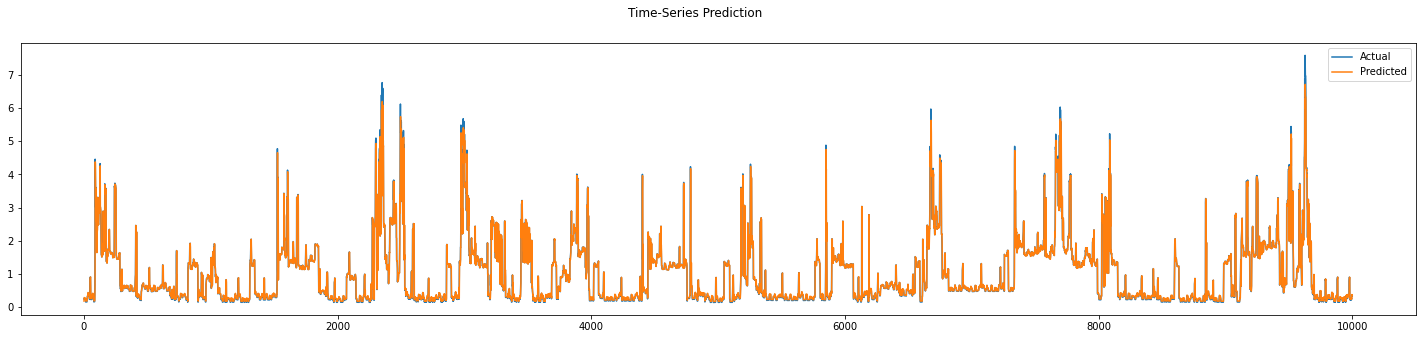

In [15]:
import matplotlib.pyplot as plt

test_predict = lstm(testX)

data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

start = 0
plot_horizon = 10000

plt.gcf().set_size_inches(25, 5)
plt.plot(dataY_plot[start:start+plot_horizon], label='Actual')
plt.plot(data_predict[start:start+plot_horizon], label='Predicted')
plt.legend()
plt.suptitle('Time-Series Prediction')
plt.show()